
# WeightWatcher - VGG

https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96


VGG is one of the first, large scale modern architectures based on the classic convolutional model of LeCun ,, resembling a larger scale version of LeNet5.  While there are earlier models (AlexNet, etc), VGG is usefukl because:

-  There are several variants, with 11, 13, 16, and 19 layers, and with and wthout Batch Normalization
-  It is widely available in pyTorch and other frameworks
-  There are versions trained on all of ImageNet, ImageNet-1K (a smaller data set), etc.
-  Although large,  is still used in Transfer Learning.

The general VGG series architecture consists of 

-  Several sets of Conv2D+ReLU layers (followed by Max Pooling), with feature maps increasing in size
-  3 final Fully Connected (Dense/Linear) layers

Below we show the VGG16 architecture, consisting of 16 layers.

The VGG series are considered very large models, with an enormous number of parameters comparexd to later models like ResNet and DenseNet series.  Most notably, compared to later models,

-  VGG models contain large, FC layers at the end
-  VGG does not contain residual connections


It is noted that the VGGNet model (16?) has ov er 2X the number of parameters as one of the largest ResNet models, with far less top5 accuracy.  

## Summary of results


We first compute the Average Alpha $\langle\alpha\rangle$ for all models, and compare to the Test Accuracy accross the models.  In contrast to expectations, and other models like ResNet, on average, $\langle\alpha\rangle$ is increasing with Test Accuracy instead of decreasing.  In fact, $\langle\alpha\rangle$ is strongly *negatively correlated* with reported Test Accuracy.  

#### Why is this ?

If we look at $\alpha$ vs Layer Id, we see that  $\alpha$ is increasing with Layer Id. That is, as information flows thorugh the network, the layers are less and less correlated.  THis suggests (to me) that the VGG networks are fairly bad at funneling information through the network.

Instead, we need to use the Weighted Alpha metric $\hat{\alpha}$ , which is positively correlated with the Test Accuracy.  

## Calculation of Results

In [1]:
REPEAT = False # set true to rerun weightwatcher calculations from scratch
SAVE_DATA = False # DO NOT set True unless you want to replace all files in ./data

In [2]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext watermark
%watermark

2021-01-02T23:38:39-08:00

CPython 3.8.5
IPython 7.18.1

compiler   : Clang 10.0.0 
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit


### Import WeightWatcher

set custom Logging at WARN Level

In [4]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

import weightwatcher as ww
import torchvision.models as models

ww.__version__

'0.4.0'

###  Helper Notebook to make Plots


In [5]:
import import_ipynb
import ModelPlots as MP

importing Jupyter notebook from ModelPlots.ipynb


### Create all models now

Pick colors from https://matplotlib.org/3.1.0/gallery/color/named_colors.html

In [6]:
series_name = 'VGG'
all_names = [ 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']
colors =    ['indigo', 'blue',    'purple',  'cyan',   'darkgreen','goldenrod','darkorange','red']


all_models = []
all_models.append(models.vgg11(pretrained=True))
all_models.append(models.vgg11_bn(pretrained=True))

all_models.append(models.vgg13(pretrained=True))
all_models.append(models.vgg13_bn(pretrained=True))

all_models.append(models.vgg16(pretrained=True))
all_models.append(models.vgg16_bn(pretrained=True))

all_models.append(models.vgg19(pretrained=True))
all_models.append(models.vgg19_bn(pretrained=True))


### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html

<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-odd"><td><p>VGG-11</p></td>
<td><p>30.98</p></td>
<td><p>11.37</p></td>
</tr>
<tr class="row-even"><td><p>VGG-13</p></td>
<td><p>30.07</p></td>
<td><p>10.75</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-16</p></td>
<td><p>28.41</p></td>
<td><p>9.62</p></td>
</tr>
<tr class="row-even"><td><p>VGG-19</p></td>
<td><p>27.62</p></td>
<td><p>9.12</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-11 with batch normalization</p></td>
<td><p>29.62</p></td>
<td><p>10.19</p></td>
</tr>
<tr class="row-even"><td><p>VGG-13 with batch normalization</p></td>
<td><p>28.45</p></td>
<td><p>9.63</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-16 with batch normalization</p></td>
<td><p>26.63</p></td>
<td><p>8.50</p></td>
</tr>
<tr class="row-even"><td><p>VGG-19 with batch normalization</p></td>
<td><p>25.76</p></td>
<td><p>8.15</p></td>
</tr>
</tbody>
</table>
</pre>

In [7]:
top1_errors= {
    
    "vgg11": 30.98,
    "vgg11_bn": 29.62,
    "vgg13": 30.07,
    "vgg13_bn": 28.45,
    "vgg16": 28.41,
    "vgg16_bn": 26.63,
    "vgg19": 27.62,
    "vgg19_bn": 25.76,
}

In [8]:
top5_errors= {
    
    "vgg11": 11.37,
    "vgg11_bn": 10.19,
    "vgg13": 10.75,
    "vgg13_bn": 9.63,
    "vgg16": 9.62,
    "vgg16_bn": 8.50,
    "vgg19": 9.12,
    "vgg19_bn": 8.15,
}

### Run WeightWatcher, collect summary and details (as dataframes) for all models

In [9]:
# ww0.4 using 0.38 back compatability
all_details = []
all_summaries = []
for im, name in enumerate(tqdm(all_names)):
    print(name)
    model = all_models[im]
    watcher = ww.WeightWatcher(model)
    details = watcher.analyze(mp_fit=True)#, ww2x=True)#, plot=True)
    display(details)
    summary =  watcher.get_summary()
    all_summaries.append(summary)
    all_details.append(details)


  0%|          | 0/8 [00:00<?, ?it/s]INFO:weightwatcher:

python      version 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy       version 1.18.5
tensforflow version 2.3.0
keras       version 2.4.0
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'min_evals': 0, 'max_evals': None, 'plot': False, 'mp_fit': True, 'ww2x': False}
INFO:weightwatcher:LAYER: 2 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 2 None 
INFO:weightwatcher:Randomizing Layer: 2 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 2 None 


vgg11


INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:LAYER: 8 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 8 None 
INFO:weightwatcher:Randomizing Layer: 8 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 8 None 
INFO:weightwatcher:LAYER: 10 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 10 None 
INFO:weightwatcher:Randomizing Layer: 10 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 10 None 
INFO:weightwatcher:LAYER: 13 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 13 None

,layer_id,name,D,M,N,alpha,alpha_weighted,has_esd,lambda_max,layer_type,...,rand_sigma_mp,rank_loss,rf,sigma,sigma_mp,spectral_norm,stable_rank,sv_max,xmax,xmin
0,2,None,0.240111,3.0,64.0,2.400712,2.627967,1.0,12.435451,LAYER_TYPE.CONV2D,...,1.000000,0.0,9.0,0.339723,0.805625,12.435451,8.848997,3.526393,12.435451,2.575715
1,5,None,0.112669,64.0,128.0,7.116304,4.721276,1.0,4.607285,LAYER_TYPE.CONV2D,...,0.550605,0.0,9.0,1.579223,0.400000,4.607285,34.178218,2.146459,4.607285,2.090480
2,8,None,0.076209,128.0,256.0,2.981087,1.739893,1.0,3.833927,LAYER_TYPE.CONV2D,...,0.455127,0.0,9.0,0.199107,0.376289,3.833927,53.433288,1.958042,3.833927,0.571196
3,10,None,0.068890,256.0,256.0,5.667264,2.600458,1.0,2.876445,LAYER_TYPE.CONV2D,...,0.935859,0.0,9.0,0.852122,0.952441,2.876445,91.170964,1.696008,2.876445,1.032077
4,13,None,0.084938,256.0,512.0,2.593428,1.432684,1.0,3.568032,LAYER_TYPE.CONV2D,...,0.428594,0.0,9.0,0.088798,0.396016,3.568032,98.740908,1.888923,3.568032,0.299071
5,15,None,0.038416,512.0,512.0,3.309962,2.216486,1.0,4.673487,LAYER_TYPE.CONV2D,...,0.938672,0.0,9.0,0.203381,0.949805,4.673487,91.417397,2.161825,4.673487,0.493246
6,18,None,0.052924,512.0,512.0,3.446656,1.859810,1.0,3.464163,LAYER_TYPE.CONV2D,...,0.888750,0.0,9.0,0.197800,0.949805,3.464163,132.619054,1.861226,3.464163,0.498711
7,20,None,0.034290,512.0,512.0,3.261262,2.524426,1.0,5.943799,LAYER_TYPE.CONV2D,...,0.942100,0.0,9.0,0.108921,0.949316,5.943799,70.814323,2.437991,5.943799,0.237964
8,25,None,0.032563,4096.0,25088.0,2.325065,3.583809,1.0,34.784030,LAYER_TYPE.DENSE,...,0.898330,0.0,1.0,0.028604,0.619980,34.784030,94.707780,5.897799,34.784030,0.380772
9,28,None,0.030891,4096.0,4096.0,2.167513,3.858526,1.0,60.278519,LAYER_TYPE.DENSE,...,0.959863,0.0,1.0,0.034133,0.963086,60.278519,31.849728,7.763924,60.278519,0.341789


 12%|█▎        | 1/8 [07:23<51:47, 443.90s/it]INFO:weightwatcher:

python      version 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy       version 1.18.5
tensforflow version 2.3.0
keras       version 2.4.0
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'min_evals': 0, 'max_evals': None, 'plot': False, 'mp_fit': True, 'ww2x': False}
INFO:weightwatcher:LAYER: 2 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 2 None 
INFO:weightwatcher:Randomizing Layer: 2 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 2 None 


vgg11_bn


INFO:weightwatcher:Layer id 3  unknown type 1 layer  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 6 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 6 None 
INFO:weightwatcher:Randomizing Layer: 6 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 6 None 
INFO:weightwatcher:Layer id 7  unknown type 1 layer  BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 10 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 10 None 
INFO:weightwatcher:Randomizing Layer: 10 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 10 None 
INFO:weightwatcher:Layer id 11  unknown type 1 layer  BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:wei

,layer_id,name,D,M,N,alpha,alpha_weighted,has_esd,lambda_max,layer_type,...,rand_sigma_mp,rank_loss,rf,sigma,sigma_mp,spectral_norm,stable_rank,sv_max,xmax,xmin
0,2,None,0.260882,3.0,64.0,1.644614,1.455792,1.0,7.676933,LAYER_TYPE.CONV2D,...,1.000000,0.0,9.0,0.124056,0.999999,7.676933,7.475631,2.770728,7.676933,0.240965
1,6,None,0.075592,64.0,128.0,4.486619,2.113689,1.0,2.958759,LAYER_TYPE.CONV2D,...,0.435039,0.0,9.0,0.573197,0.300000,2.958759,31.762414,1.720104,2.958759,0.950782
2,10,None,0.102256,128.0,256.0,1.919988,0.776929,1.0,2.538942,LAYER_TYPE.CONV2D,...,0.396797,0.0,9.0,0.047257,0.358672,2.538942,56.272339,1.593406,2.538942,0.076871
3,13,None,0.058838,256.0,256.0,6.815435,1.456881,1.0,1.635920,LAYER_TYPE.CONV2D,...,0.871260,0.0,9.0,0.982988,0.951270,1.635920,113.672779,1.279031,1.635920,0.661637
4,17,None,0.088184,256.0,512.0,2.491112,0.866386,1.0,2.227362,LAYER_TYPE.CONV2D,...,0.397969,0.0,9.0,0.072330,0.376641,2.227362,130.279183,1.492435,2.227362,0.195610
5,20,None,0.029487,512.0,512.0,2.912103,1.463396,1.0,3.180696,LAYER_TYPE.CONV2D,...,0.906680,0.0,9.0,0.098609,0.955078,3.180696,119.046905,1.783450,3.180696,0.237017
6,24,None,0.033931,512.0,512.0,3.368882,1.593598,1.0,2.971903,LAYER_TYPE.CONV2D,...,0.839219,0.0,9.0,0.185545,0.954102,2.971903,131.765424,1.723921,2.971903,0.397672
7,27,None,0.040454,512.0,512.0,3.679492,3.809824,1.0,10.849782,LAYER_TYPE.CONV2D,...,0.944561,0.0,9.0,0.125479,0.949414,10.849782,31.613107,3.293901,10.849782,0.190394
8,33,None,0.031060,4096.0,25088.0,2.071125,2.914886,1.0,25.550091,LAYER_TYPE.DENSE,...,0.835781,0.0,1.0,0.022452,0.522266,25.550091,111.711467,5.054710,25.550091,0.216972
9,36,None,0.033582,4096.0,4096.0,1.950355,3.346949,1.0,52.008137,LAYER_TYPE.DENSE,...,0.958398,0.0,1.0,0.025220,0.967969,52.008137,35.145237,7.211667,52.008137,0.180731


 25%|██▌       | 2/8 [14:39<44:08, 441.39s/it]INFO:weightwatcher:

python      version 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy       version 1.18.5
tensforflow version 2.3.0
keras       version 2.4.0
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'min_evals': 0, 'max_evals': None, 'plot': False, 'mp_fit': True, 'ww2x': False}
INFO:weightwatcher:LAYER: 2 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 2 None 
INFO:weightwatcher:Randomizing Layer: 2 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 2 None 
INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>


vgg13


INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO:weightwatcher:Randomizing Layer: 4 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 4 None 
INFO:weightwatcher:LAYER: 7 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 7 None 
INFO:weightwatcher:Randomizing Layer: 7 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 7 None 
INFO:weightwatcher:LAYER: 9 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 9 None 
INFO:weightwatcher:Randomizing Layer: 9 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 9 None 
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
INFO:weightwatcher:Randomizing Layer: 12 None 
INFO:weightwatcher:generati

,layer_id,name,D,M,N,alpha,alpha_weighted,has_esd,lambda_max,layer_type,...,rand_sigma_mp,rank_loss,rf,sigma,sigma_mp,spectral_norm,stable_rank,sv_max,xmax,xmin
0,2,None,0.229375,3.0,64.0,1.774613,1.449051,1.0,6.554575,LAYER_TYPE.CONV2D,...,1.000000,0.0,9.0,0.151914,0.882510,6.554575,8.569489,2.560190,6.554575,0.395595
1,4,None,0.147615,64.0,64.0,4.452121,1.162829,1.0,1.824674,LAYER_TYPE.CONV2D,...,0.859131,0.0,9.0,0.719817,0.963672,1.824674,34.568238,1.350805,1.824674,0.756671
2,7,None,0.100679,64.0,128.0,1.795199,0.793852,1.0,2.768270,LAYER_TYPE.CONV2D,...,0.463965,0.0,9.0,0.050293,0.376328,2.768270,38.478540,1.663812,2.768270,0.069920
3,9,None,0.073514,128.0,128.0,9.917214,1.673969,1.0,1.475008,LAYER_TYPE.CONV2D,...,0.893584,0.0,9.0,2.383226,0.938320,1.475008,87.500480,1.214499,1.475008,0.838343
4,12,None,0.080638,128.0,256.0,2.747808,1.212567,1.0,2.762391,LAYER_TYPE.CONV2D,...,0.431074,0.0,9.0,0.139937,0.381875,2.762391,66.225093,1.662044,2.762391,0.330521
5,14,None,0.063435,256.0,256.0,3.206638,1.352162,1.0,2.640437,LAYER_TYPE.CONV2D,...,0.917051,0.0,9.0,0.186495,0.951074,2.640437,85.351445,1.624942,2.640437,0.371219
6,17,None,0.072551,256.0,512.0,2.948956,1.382335,1.0,2.942754,LAYER_TYPE.CONV2D,...,0.421641,0.0,9.0,0.126067,0.383203,2.942754,111.259895,1.715446,2.942754,0.362457
7,19,None,0.034782,512.0,512.0,3.189143,2.093100,1.0,4.532320,LAYER_TYPE.CONV2D,...,0.939727,0.0,9.0,0.148609,0.949512,4.532320,89.404738,2.128925,4.532320,0.344201
8,22,None,0.049586,512.0,512.0,3.864773,1.947275,1.0,3.190454,LAYER_TYPE.CONV2D,...,0.895166,0.0,9.0,0.307136,0.949414,3.190454,138.602332,1.786184,3.190454,0.614937
9,24,None,0.032441,512.0,512.0,3.380506,2.493365,1.0,5.464764,LAYER_TYPE.CONV2D,...,0.942451,0.0,9.0,0.117997,0.949316,5.464764,73.369096,2.337684,5.464764,0.234645


 38%|███▊      | 3/8 [21:51<36:33, 438.72s/it]INFO:weightwatcher:

python      version 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy       version 1.18.5
tensforflow version 2.3.0
keras       version 2.4.0
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'min_evals': 0, 'max_evals': None, 'plot': False, 'mp_fit': True, 'ww2x': False}
INFO:weightwatcher:LAYER: 2 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 2 None 
INFO:weightwatcher:Randomizing Layer: 2 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 2 None 
INFO:weightwatcher:Layer id 3  unknown type 1 layer  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


vgg13_bn


INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:Layer id 6  unknown type 1 layer  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 9 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 9 None 
INFO:weightwatcher:Randomizing Layer: 9 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 9 None 
INFO:weightwatcher:Layer id 10  unknown type 1 layer  BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
INFO:weightwatcher:Randomiz

,layer_id,name,D,M,N,alpha,alpha_weighted,has_esd,lambda_max,layer_type,...,rand_sigma_mp,rank_loss,rf,sigma,sigma_mp,spectral_norm,stable_rank,sv_max,xmax,xmin
0,2,None,0.142182,3.0,64.0,7.515273,4.562136,1.0,4.046212,LAYER_TYPE.CONV2D,...,1.000000,0.0,9.0,2.303497,0.702803,4.046212,8.104247,2.011520,4.046212,2.511328
1,5,None,0.106055,64.0,64.0,2.978054,0.411609,1.0,1.374719,LAYER_TYPE.CONV2D,...,0.870908,0.0,9.0,0.308920,1.071387,1.374719,19.977133,1.172484,1.374719,0.246934
2,9,None,0.106122,64.0,128.0,1.804345,0.520258,1.0,1.942388,LAYER_TYPE.CONV2D,...,0.394492,0.0,9.0,0.061873,0.330469,1.942388,36.382329,1.393696,1.942388,0.066755
3,12,None,0.111111,128.0,128.0,9.668555,0.168675,1.0,1.040988,LAYER_TYPE.CONV2D,...,0.832188,0.0,9.0,2.889518,0.975391,1.040988,75.347706,1.020288,1.040988,0.672417
4,16,None,0.098321,128.0,256.0,2.858658,0.633712,1.0,1.666026,LAYER_TYPE.CONV2D,...,0.385430,0.0,9.0,0.157085,0.373320,1.666026,80.796016,1.290746,1.666026,0.279788
5,19,None,0.076852,256.0,256.0,3.884498,0.845759,1.0,1.650922,LAYER_TYPE.CONV2D,...,0.839844,0.0,9.0,0.299108,0.956250,1.650922,104.675670,1.284882,1.650922,0.367323
6,23,None,0.083359,256.0,512.0,3.268899,0.803001,1.0,1.760552,LAYER_TYPE.CONV2D,...,0.391191,0.0,9.0,0.173507,0.358125,1.760552,155.878254,1.326858,1.760552,0.370742
7,26,None,0.027645,512.0,512.0,3.000914,1.428143,1.0,2.991594,LAYER_TYPE.CONV2D,...,0.899736,0.0,9.0,0.103189,0.957520,2.991594,121.040529,1.729623,2.991594,0.228030
8,30,None,0.042926,512.0,512.0,3.258218,1.305825,1.0,2.516396,LAYER_TYPE.CONV2D,...,0.833984,0.0,9.0,0.141415,0.957617,2.516396,147.664264,1.586315,2.516396,0.300166
9,33,None,0.040767,512.0,512.0,3.762326,3.129799,1.0,6.790139,LAYER_TYPE.CONV2D,...,0.930762,0.0,9.0,0.131839,0.949512,6.790139,48.348580,2.605789,6.790139,0.185570


 50%|█████     | 4/8 [29:45<29:57, 449.30s/it]INFO:weightwatcher:

python      version 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy       version 1.18.5
tensforflow version 2.3.0
keras       version 2.4.0
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'min_evals': 0, 'max_evals': None, 'plot': False, 'mp_fit': True, 'ww2x': False}
INFO:weightwatcher:LAYER: 2 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 2 None 
INFO:weightwatcher:Randomizing Layer: 2 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 2 None 


vgg16


INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO:weightwatcher:Randomizing Layer: 4 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 4 None 
INFO:weightwatcher:LAYER: 7 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 7 None 
INFO:weightwatcher:Randomizing Layer: 7 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 7 None 
INFO:weightwatcher:LAYER: 9 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 9 None 
INFO:weightwatcher:Randomizing Layer: 9 None 
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 9 None 
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
IN

,layer_id,name,D,M,N,alpha,alpha_weighted,has_esd,lambda_max,layer_type,...,rand_sigma_mp,rank_loss,rf,sigma,sigma_mp,spectral_norm,stable_rank,sv_max,xmax,xmin
0,2,None,0.170512,3.0,64.0,2.717124,2.341765,1.0,7.275356,LAYER_TYPE.CONV2D,...,1.000000,0.0,9.0,0.443359,0.760625,7.275356,7.472150,2.697287,7.275356,1.513359
1,4,None,0.096156,64.0,64.0,2.651562,0.931538,1.0,2.245518,LAYER_TYPE.CONV2D,...,0.854121,0.0,9.0,0.216861,0.968359,2.245518,25.618823,1.498505,2.245518,0.306328
2,7,None,0.072822,64.0,128.0,6.345446,2.612707,1.0,2.580746,LAYER_TYPE.CONV2D,...,0.439922,0.0,9.0,1.296461,0.365469,2.580746,35.268130,1.606470,2.580746,1.089533
3,9,None,0.137568,128.0,128.0,1.992444,0.054446,1.0,1.064943,LAYER_TYPE.CONV2D,...,0.848760,0.0,9.0,0.052234,0.917930,1.064943,102.696774,1.031961,1.064943,0.073679
4,12,None,0.087411,128.0,256.0,3.791835,1.069167,1.0,1.914104,LAYER_TYPE.CONV2D,...,0.399688,0.0,9.0,0.376451,0.365859,1.914104,77.930000,1.383511,1.914104,0.571380
5,14,None,0.092079,256.0,256.0,3.274249,0.681662,1.0,1.615061,LAYER_TYPE.CONV2D,...,0.851572,0.0,9.0,0.195736,0.945000,1.615061,110.236924,1.270850,1.615061,0.316025
6,16,None,0.064152,256.0,256.0,3.330447,1.042765,1.0,2.056366,LAYER_TYPE.CONV2D,...,0.878027,0.0,9.0,0.201320,0.950781,2.056366,92.366475,1.434004,2.056366,0.320518
7,19,None,0.072760,256.0,512.0,3.507229,1.118041,1.0,2.083444,LAYER_TYPE.CONV2D,...,0.395859,0.0,9.0,0.208936,0.372285,2.083444,132.001482,1.443414,2.083444,0.426477
8,21,None,0.038090,512.0,512.0,3.179354,1.420746,1.0,2.798119,LAYER_TYPE.CONV2D,...,0.884180,0.0,9.0,0.138111,0.952637,2.798119,113.210950,1.672758,2.798119,0.265553
9,23,None,0.030176,512.0,512.0,3.270175,1.644904,1.0,3.184211,LAYER_TYPE.CONV2D,...,0.895254,0.0,9.0,0.139720,0.950977,3.184211,99.004456,1.784436,3.184211,0.238642


 62%|██████▎   | 5/8 [40:13<25:08, 502.93s/it]INFO:weightwatcher:

python      version 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy       version 1.18.5
tensforflow version 2.3.0
keras       version 2.4.0
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'min_evals': 0, 'max_evals': None, 'plot': False, 'mp_fit': True, 'ww2x': False}
INFO:weightwatcher:LAYER: 2 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 2 None 
INFO:weightwatcher:Randomizing Layer: 2 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 2 None 
INFO:weightwatcher:Layer id 3  unknown type 1 layer  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>


vgg16_bn


INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:Layer id 6  unknown type 1 layer  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 9 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 9 None 
INFO:weightwatcher:Randomizing Layer: 9 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 9 None 
INFO:weightwatcher:Layer id 10  unknown type 1 layer  BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 12 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 12 None 
INFO:weightwatcher:Randomizing Layer: 12 None 
INFO:weightwatcher:generating 1 replicas for each W 

,layer_id,name,D,M,N,alpha,alpha_weighted,has_esd,lambda_max,layer_type,...,rand_sigma_mp,rank_loss,rf,sigma,sigma_mp,spectral_norm,stable_rank,sv_max,xmax,xmin
0,2,None,0.145384,3.0,64.0,6.327672,4.150097,1.0,4.527566,LAYER_TYPE.CONV2D,...,0.997383,0.0,9.0,1.775891,0.657412,4.527566,6.227025,2.127808,4.527566,1.897258
1,5,None,0.073587,64.0,64.0,2.845237,0.537333,1.0,1.544733,LAYER_TYPE.CONV2D,...,0.830313,0.0,9.0,0.291758,1.078320,1.544733,15.024099,1.242873,1.544733,0.194930
2,9,None,0.111295,64.0,128.0,1.688684,0.416330,1.0,1.764172,LAYER_TYPE.CONV2D,...,0.369727,0.0,9.0,0.045609,0.318662,1.764172,32.600952,1.328221,1.764172,0.028456
3,12,None,0.105480,128.0,128.0,3.267204,-0.303635,1.0,0.807357,LAYER_TYPE.CONV2D,...,0.812344,0.0,9.0,0.231396,0.931729,0.807357,76.745883,0.898531,0.807357,0.203016
4,16,None,0.083573,128.0,256.0,5.203093,0.679186,1.0,1.350626,LAYER_TYPE.CONV2D,...,0.349746,0.0,9.0,0.896102,0.349648,1.350626,73.492561,1.162164,1.350626,0.588438
5,19,None,0.070851,256.0,256.0,6.308922,1.401821,1.0,1.668002,LAYER_TYPE.CONV2D,...,0.810547,0.0,9.0,1.370758,0.959180,1.668002,73.780844,1.291512,1.668002,0.586793
6,22,None,0.086613,256.0,256.0,7.194564,0.459975,1.0,1.158601,LAYER_TYPE.CONV2D,...,0.813125,0.0,9.0,1.291656,0.925840,1.158601,119.085209,1.076383,1.158601,0.520586
7,26,None,0.101513,256.0,512.0,2.683498,0.191625,1.0,1.178715,LAYER_TYPE.CONV2D,...,0.362656,0.0,9.0,0.086935,0.338516,1.178715,184.997071,1.085686,1.178715,0.171676
8,29,None,0.041658,512.0,512.0,3.030338,0.977358,1.0,2.101475,LAYER_TYPE.CONV2D,...,0.815469,0.0,9.0,0.108217,0.955078,2.101475,134.471354,1.449647,2.101475,0.194637
9,32,None,0.023353,512.0,512.0,3.194871,1.180587,1.0,2.341671,LAYER_TYPE.CONV2D,...,0.887256,0.0,9.0,0.128887,0.953418,2.341671,125.228223,1.530252,2.341671,0.209709


 75%|███████▌  | 6/8 [1:29:32<41:19, 1239.59s/it]INFO:weightwatcher:

python      version 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy       version 1.18.5
tensforflow version 2.3.0
keras       version 2.4.0
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'min_evals': 0, 'max_evals': None, 'plot': False, 'mp_fit': True, 'ww2x': False}
INFO:weightwatcher:LAYER: 2 8  : <class 'torch.nn.modules.conv.Conv2d'>


vgg19


INFO:weightwatcher:MP Fitting Layer: 2 None 
INFO:weightwatcher:Randomizing Layer: 2 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 2 None 
INFO:weightwatcher:LAYER: 4 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 4 None 
INFO:weightwatcher:Randomizing Layer: 4 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 4 None 
INFO:weightwatcher:LAYER: 7 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 7 None 
INFO:weightwatcher:Randomizing Layer: 7 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 7 None 
INFO:weightwatcher:LAYER: 9 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 9 None 
INFO:weightwatcher:Randomizing Layer: 9 None 
INFO:weightwatcher:generating 

,layer_id,name,D,M,N,alpha,alpha_weighted,has_esd,lambda_max,layer_type,...,rand_sigma_mp,rank_loss,rf,sigma,sigma_mp,spectral_norm,stable_rank,sv_max,xmax,xmin
0,2,None,0.200768,3.0,64.0,2.691829,2.156662,1.0,6.326864,LAYER_TYPE.CONV2D,...,1.000000,0.0,9.0,0.422957,0.682158,6.326864,8.795783,2.515326,6.326864,1.533533
1,4,None,0.143430,64.0,64.0,2.512862,0.690039,1.0,1.881928,LAYER_TYPE.CONV2D,...,0.862295,0.0,9.0,0.180822,0.966211,1.881928,30.488629,1.371834,1.881928,0.262988
2,7,None,0.069853,64.0,128.0,5.568418,2.390792,1.0,2.687501,LAYER_TYPE.CONV2D,...,0.430703,0.0,9.0,1.142104,0.368984,2.687501,32.511587,1.639360,2.687501,1.008518
3,9,None,0.129767,128.0,128.0,15.549984,0.716672,1.0,1.111958,LAYER_TYPE.CONV2D,...,0.858428,0.0,9.0,4.849995,0.920830,1.111958,96.782274,1.054494,1.111958,0.795724
4,12,None,0.064503,128.0,256.0,3.886798,1.280928,1.0,2.135791,LAYER_TYPE.CONV2D,...,0.394180,0.0,9.0,0.404233,0.374805,2.135791,65.245574,1.461434,2.135791,0.533444
5,14,None,0.087450,256.0,256.0,3.129077,0.262973,1.0,1.213505,LAYER_TYPE.CONV2D,...,0.820859,0.0,9.0,0.160485,0.928916,1.213505,128.204145,1.101592,1.213505,0.236869
6,16,None,0.084917,256.0,256.0,2.968370,0.445415,1.0,1.412713,LAYER_TYPE.CONV2D,...,0.827891,0.0,9.0,0.145905,0.938232,1.412713,109.125201,1.188576,1.412713,0.217216
7,18,None,0.040751,256.0,256.0,3.660554,1.131943,1.0,2.038108,LAYER_TYPE.CONV2D,...,0.871787,0.0,9.0,0.290290,0.952148,2.038108,79.442268,1.427623,2.038108,0.336495
8,21,None,0.082360,256.0,512.0,3.619139,0.648295,1.0,1.510531,LAYER_TYPE.CONV2D,...,0.367852,0.0,9.0,0.225420,0.360703,1.510531,155.491170,1.229037,1.510531,0.377149
9,23,None,0.043220,512.0,512.0,3.357673,0.797141,1.0,1.727463,LAYER_TYPE.CONV2D,...,0.850342,0.0,9.0,0.152825,0.948340,1.727463,156.281381,1.314330,1.727463,0.237887


 88%|████████▊ | 7/8 [3:31:02<50:54, 3054.65s/it]INFO:weightwatcher:

python      version 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy       version 1.18.5
tensforflow version 2.3.0
keras       version 2.4.0
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'min_evals': 0, 'max_evals': None, 'plot': False, 'mp_fit': True, 'ww2x': False}
INFO:weightwatcher:LAYER: 2 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 2 None 


vgg19_bn


INFO:weightwatcher:Randomizing Layer: 2 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 2 None 
INFO:weightwatcher:Layer id 3  unknown type 1 layer  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 5 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 5 None 
INFO:weightwatcher:Randomizing Layer: 5 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fitting Random layer: 5 None 
INFO:weightwatcher:Layer id 6  unknown type 1 layer  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
INFO:weightwatcher:LAYER: 9 8  : <class 'torch.nn.modules.conv.Conv2d'>
INFO:weightwatcher:MP Fitting Layer: 9 None 
INFO:weightwatcher:Randomizing Layer: 9 None 
INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:MP Fi

,layer_id,name,D,M,N,alpha,alpha_weighted,has_esd,lambda_max,layer_type,...,rand_sigma_mp,rank_loss,rf,sigma,sigma_mp,spectral_norm,stable_rank,sv_max,xmax,xmin
0,2,None,0.240572,3.0,64.0,5.985486,3.845033,1.0,4.389275,LAYER_TYPE.CONV2D,...,0.916128,0.0,9.0,1.661829,0.463901,4.389275,4.833714,2.095060,4.389275,1.410407
1,5,None,0.090739,64.0,64.0,2.449748,0.446221,1.0,1.521072,LAYER_TYPE.CONV2D,...,0.843906,0.0,9.0,0.218558,1.136816,1.521072,12.077875,1.233317,1.521072,0.132103
2,9,None,0.105488,64.0,128.0,1.663159,0.482488,1.0,1.950309,LAYER_TYPE.CONV2D,...,0.336606,0.0,9.0,0.049987,0.300000,1.950309,22.975615,1.396535,1.950309,0.025917
3,12,None,0.096102,128.0,128.0,4.071072,-0.092965,1.0,0.948778,LAYER_TYPE.CONV2D,...,0.805078,0.0,9.0,0.468334,1.033984,0.948778,52.385034,0.974052,0.948778,0.308189
4,16,None,0.081037,128.0,256.0,3.713905,0.572822,1.0,1.426386,LAYER_TYPE.CONV2D,...,0.315132,0.0,9.0,0.452318,0.327715,1.426386,53.269349,1.194314,1.426386,0.401765
5,19,None,0.041393,256.0,256.0,3.980314,0.569810,1.0,1.390456,LAYER_TYPE.CONV2D,...,0.793984,0.0,9.0,0.344137,0.997949,1.390456,62.524642,1.179176,1.390456,0.256443
6,22,None,0.076931,256.0,256.0,3.545362,0.324410,1.0,1.234533,LAYER_TYPE.CONV2D,...,0.799141,0.0,9.0,0.302079,0.977734,1.234533,73.827060,1.111095,1.234533,0.258409
7,25,None,0.091756,256.0,256.0,2.868920,-0.040986,1.0,0.967640,LAYER_TYPE.CONV2D,...,0.831094,0.0,9.0,0.127757,0.944824,0.967640,111.304849,0.983687,0.967640,0.145085
8,29,None,0.095060,256.0,512.0,5.094775,0.033781,1.0,1.015384,LAYER_TYPE.CONV2D,...,0.329883,0.0,9.0,0.552139,0.341602,1.015384,165.149926,1.007663,1.015384,0.460054
9,32,None,0.051589,512.0,512.0,3.328272,0.687279,1.0,1.608782,LAYER_TYPE.CONV2D,...,0.784141,0.0,9.0,0.157690,0.973145,1.608782,136.396810,1.268378,1.608782,0.218305


100%|██████████| 8/8 [5:12:13<00:00, 2341.68s/it]


### Fix Summaries, remove first layer from all calculations

In [10]:
for summary, details in zip(all_summaries,all_details):
    for key in summary:
        summary[key]=np.mean(details[9:][key].to_numpy())

In [11]:
plt.rcParams.update({'font.size': 20})
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

In [12]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rcParams.update(params)


In [13]:
first_n_last_ids = [0, len(all_details)-2]

saving img/VGG_log_norm_accs.png


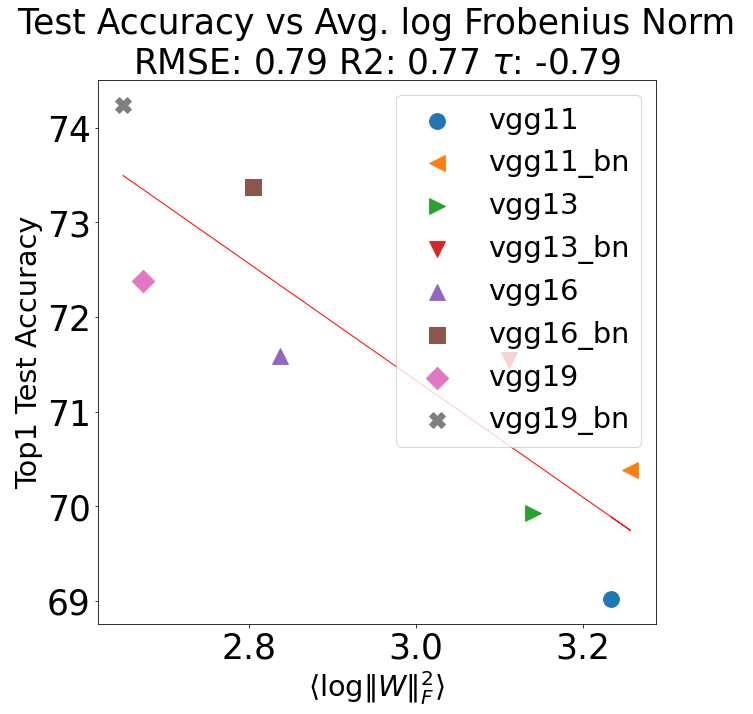

saving img/VGG_alpha_accs.png


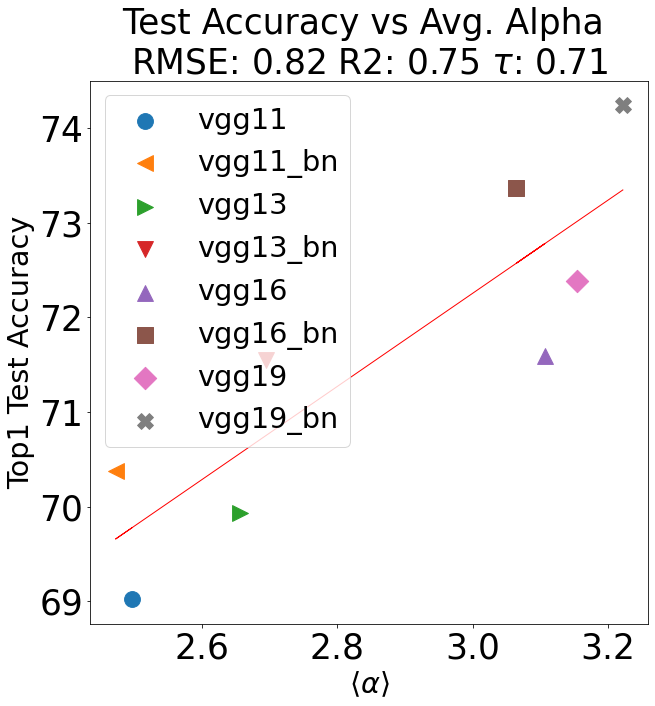

saving img/VGG_alpha_weighted_accs.png


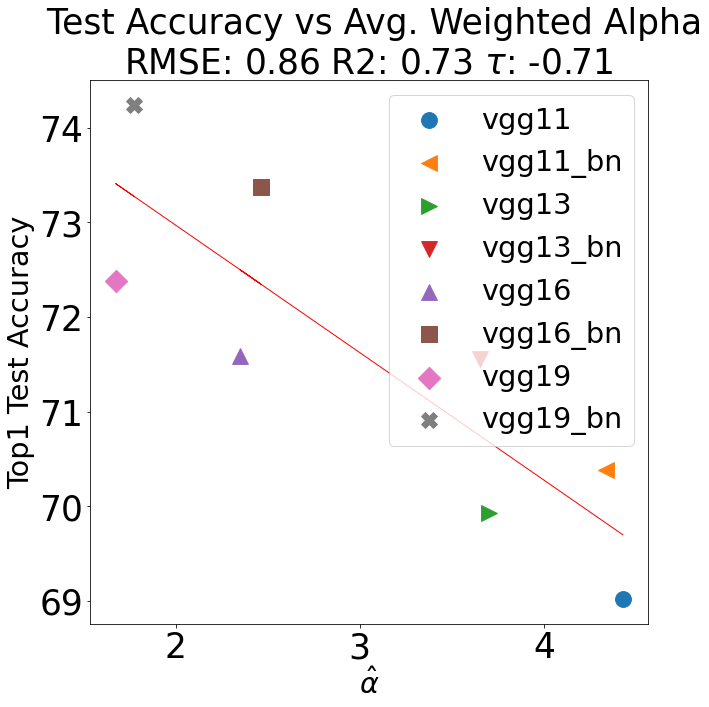

saving img/VGG_log_spectral_norm_accs.png


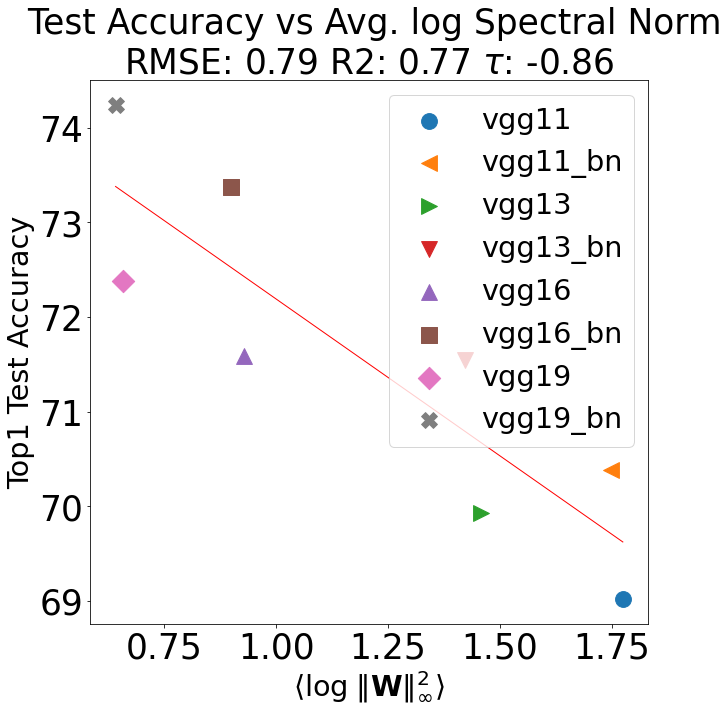

KeyError: 'log_stable_rank'

In [14]:
MP.plot_all_metrics_vs_test_accuracies( \
    series_name, all_names, colors, all_summaries, all_details, top1_errors)

In [ ]:
MP.plot_all_metric_histograms( \
    series_name, all_names, colors, all_summaries, all_details, first_n_last_ids)

In [ ]:
MP.plot_all_metric_vs_depth( \
    series_name, all_names, colors, all_summaries, all_details, first_n_last_ids)


### Cross Validation metric

- useful ?  https://codeburst.io/cross-validation-calculating-r%C2%B2-and-accuracy-scores-after-loocv-5bd1015a50ec

#### Available scores for CV

In [52]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

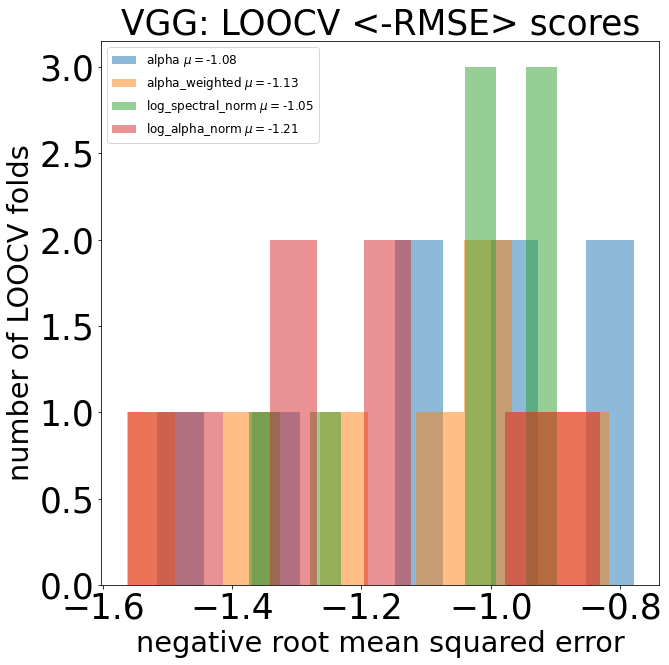

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
rcParams['figure.figsize'] = 10,10

for metric in ['alpha', 'alpha_weighted', 'log_spectral_norm', 'log_alpha_norm']:
    num = len(all_names)
    xs, ys = np.empty(num), np.empty(num)
    for im, modelname in enumerate(all_names):    

        summary = all_summaries[im]
        x = summary[metric]
        xs[im] = x

        error = top1_errors[modelname]
        y = 100.0-error
        ys[im] = y

        label = modelname
        #plt.scatter(x, y, label=label)


    xs = xs.reshape(-1,1)
    ys = ys.reshape(-1,1)
    regr = LinearRegression()
    #regr.fit(xs, ys)
    #y_pred = regr.predict(xs)
    #plt.plot(xs, y_pred, color='red', linewidth=1)

    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import LeaveOneOut
    loo = LeaveOneOut()
    scores = cross_val_score(regr, xs, ys, cv=loo, scoring='neg_root_mean_squared_error')

    mean_score = np.mean(scores)
    plt.title("VGG: LOOCV <-RMSE> scores")
    plt.hist(scores, alpha=0.5, label=r"{} $\mu=${:0.3}".format(metric, mean_score) )
    plt.legend(loc = 'upper left', fontsize=12)
    plt.xlabel("negative root mean squared error")
    plt.ylabel("number of LOOCV folds")

(array([1., 0., 1., 0., 0., 2., 0., 2., 0., 2.]),
 array([-1.51645819, -1.44269367, -1.36892914, -1.29516462, -1.22140009,
        -1.14763556, -1.07387104, -1.00010651, -0.92634199, -0.85257746,
        -0.77881293]),
 <BarContainer object of 10 artists>)

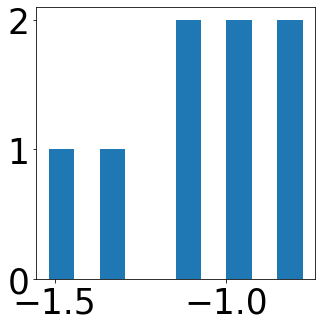

In [57]:
plt.hist(scores)

### Plot Residuals

<pre>
!pip install yellowbrick

!pip install statsmodels
</pre>

                  VGG alpha Residuals


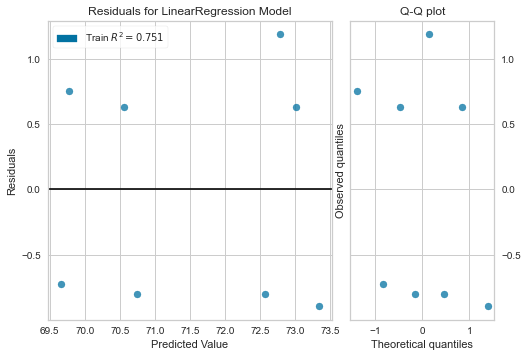

                  VGG alpha_weighted Residuals


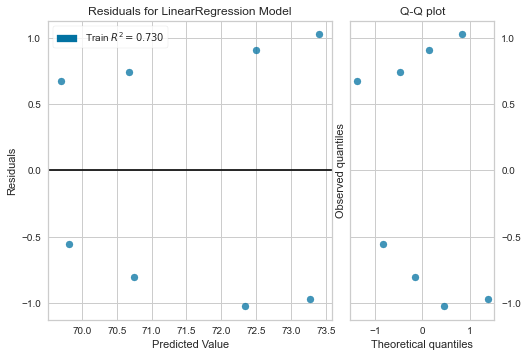

                  VGG log_spectral_norm Residuals


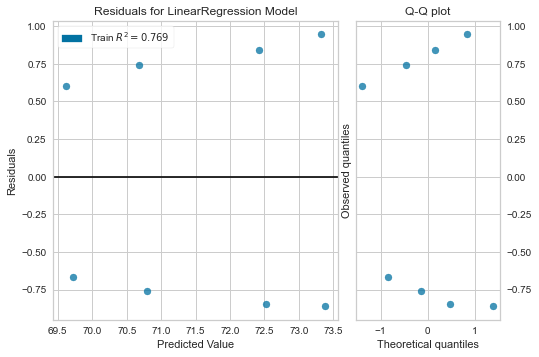

                  VGG log_alpha_norm Residuals


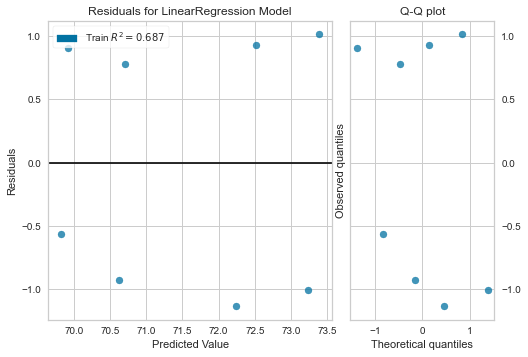

In [117]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot


for metric in ['alpha', 'alpha_weighted', 'log_spectral_norm', 'log_alpha_norm']:
    title = "VGG {} Residuals".format(metric)
    
    num = len(all_names)
    xs, ys = np.empty(num), np.empty(num)
    for im, modelname in enumerate(all_names):    

        summary = all_summaries[im]
        x = summary[metric]
        xs[im] = x

        error = top1_errors[modelname]
        y = 100.0-error
        ys[im] = y

        label = modelname
        #plt.scatter(x, y, label=label)


    xs = xs.reshape(-1,1)
    ys = ys.reshape(-1,1)
    regr = LinearRegression()
    

    
    visualizer = ResidualsPlot(regr, hist=False, qqplot=True)
    visualizer.fit(xs, ys)  # Fit the training data to the visualizer
    #visualizer.score(xs, ys)  # Evaluate the model on the test data
    print("                  "+title)
    visualizer.show()   


                  VGG alpha Residuals


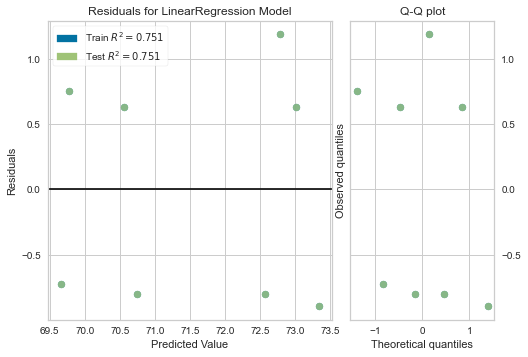

                  VGG alpha_weighted Residuals


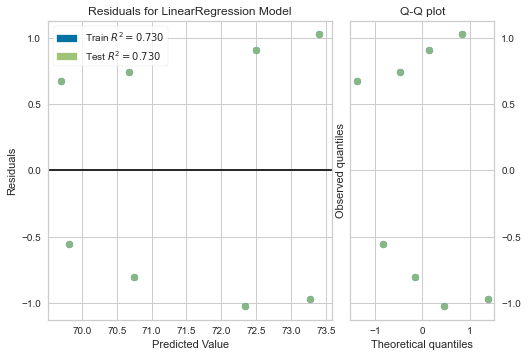

                  VGG log_spectral_norm Residuals


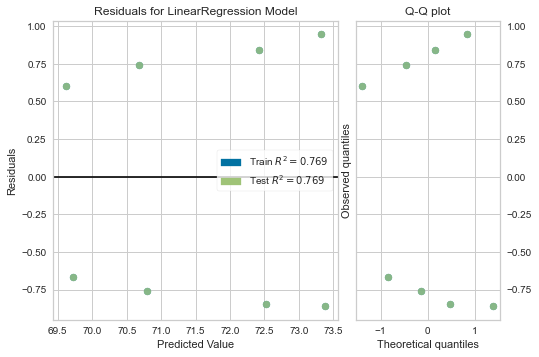

                  VGG log_alpha_norm Residuals


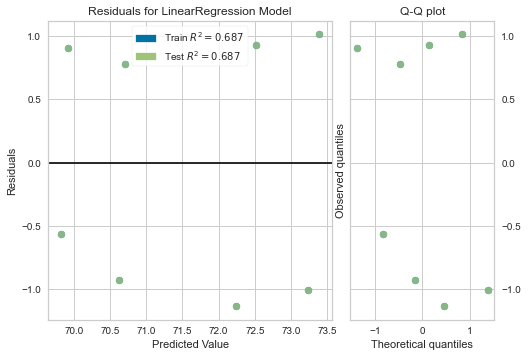

In [159]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import prediction_error

for metric in ['alpha', 'alpha_weighted', 'log_spectral_norm', 'log_alpha_norm']:
    
    num = len(all_names)
    xs, ys = np.empty(num), np.empty(num)
    
    for im, modelname in enumerate(all_names):    

        summary = all_summaries[im]
        x = summary[metric]
        xs[im] = x

        error = top1_errors[modelname]
        y = 100.0-error
        ys[im] = y

        label = modelname
        #plt.scatter(x, y, label=label)


    
    xs = xs.reshape(-1,1)
    ys = ys.reshape(-1,1)
    regr = LinearRegression()
    
    
    title = "VGG {} Residuals".format(metric)
    visualizer = ResidualsPlot(regr, hist=False, qqplot=True)
    visualizer.fit(xs, ys)  # Fit the training data to the visualizer
    visualizer.score(xs, ys)  # Evaluate the model on the test data
    print("                  "+title)
    visualizer.show()   
    
  
    # something seems wrong ?

### Seaborn plots

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels

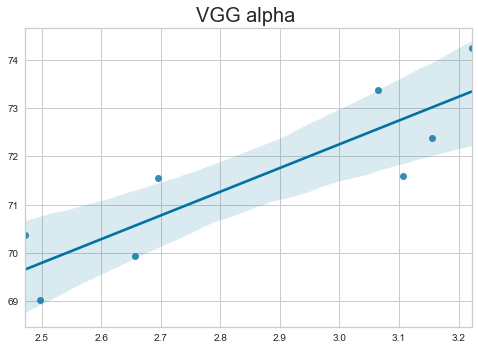

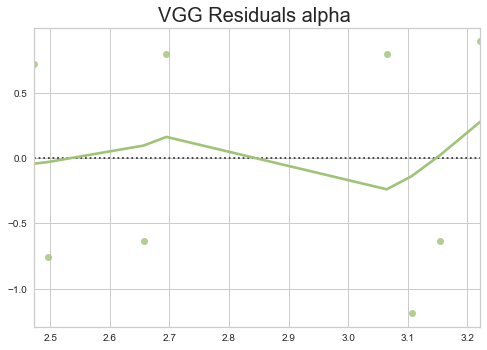

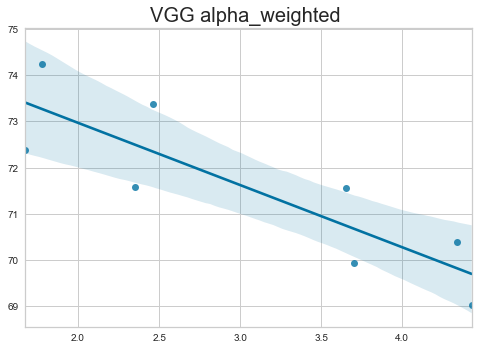

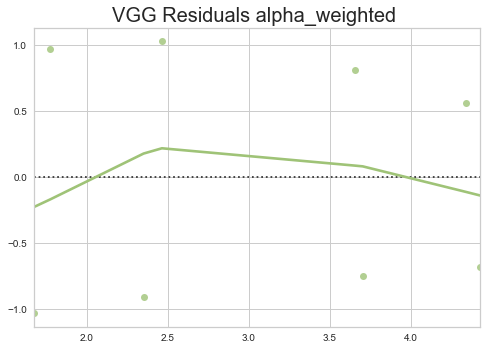

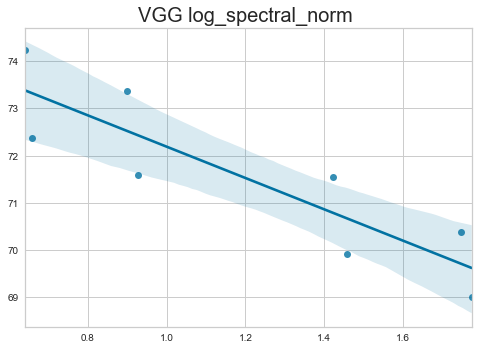

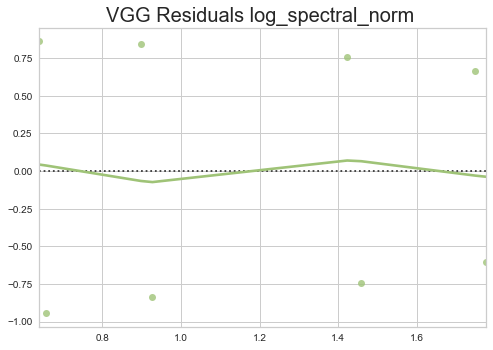

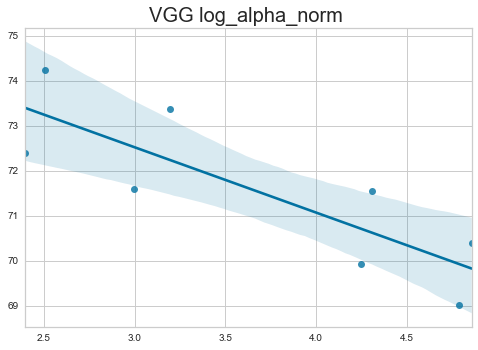

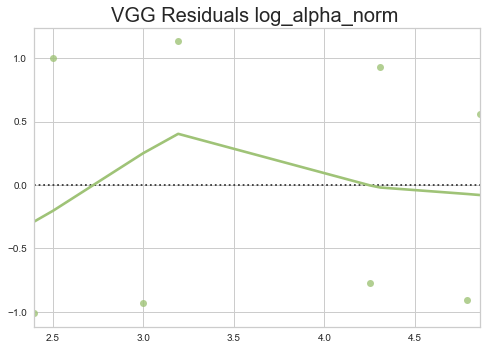

In [147]:

for metric in ['alpha', 'alpha_weighted', 'log_spectral_norm', 'log_alpha_norm']:
    
    num = len(all_names)
    xs, ys = np.empty(num), np.empty(num)
    for im, modelname in enumerate(all_names):    

        summary = all_summaries[im]
        x = summary[metric]
        xs[im] = x

        error = top1_errors[modelname]
        y = 100.0-error
        ys[im] = y


    xs = xs.reshape(-1,1)
    ys = ys.reshape(-1,1)

    
    sns.regplot(x=xs, y=ys)
    title = "VGG {} ".format(metric)
    plt.title(title, fontsize=20)
    plt.show()
    
    sns.residplot(x=xs, y=ys, lowess=True, color="g")
    title = "VGG Residuals {} ".format(metric)
    plt.show()


    
    plt.title(title, fontsize=20)
    plt.show()
    